In [1]:
import cartopy.crs as ccrs
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter)
import cartopy.feature as cfeature
import cmaps
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
from shapely import geometry
import xarray as xr 

from src import utils, plots, cesm_utils
from src.inputs import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Load observation data
prect_sources = ["GPCC", "CRUT", "APHR"]
sst_sources = ["ERSST", "HADISST", "COBESST"]

obs_msea_prect_anomalies = {source: utils.get_obs_msea_prect_anomaly_timeseries_mam(
    source) for source in prect_sources}
obs_nino34_sst_anomalies = {source: utils.get_obs_nino34_sst_anomaly_timeseries_djf(
    source) for source in sst_sources}
obs_global_sst_climatology = {key: utils.load_global_sst_data(
    path) for key, path in sst_reanalysis_source_to_file.items()}

obs_msea_prect_anomalies_list = [
    obs_msea_prect_anomalies["GPCC"],
    obs_msea_prect_anomalies["CRUT"],
    obs_msea_prect_anomalies["APHR"],
]

obs_nino34_sst_anomalies_list = [
    obs_nino34_sst_anomalies["ERSST"],
    obs_nino34_sst_anomalies["HADISST"],
    obs_nino34_sst_anomalies["COBESST"],
]

obs_global_sst_climatology_list = [
    obs_global_sst_climatology["ERSST"],
    obs_global_sst_climatology["HADISST"],
    obs_global_sst_climatology["COBESST"],
]

In [3]:
# Load CESM data
ensemble_members = models.CESM2_ensemble_members # List of CESM2 Ensemble Members

cesm_global_djf_sst_map = cesm_utils.process_cesm_ensemble(
    ensemble_members,
    CESM2_LENS2_dir,
    "SST.global.1900_2100")  # annual global DJF ssts
cesm_global_djf_sst_map = cesm_global_djf_sst_map['SST'].sel(time=slice('1900', '2100'))

In [4]:
# Regrid observed SSTs to CESM grid
obs_global_sst_climatology_list_regridded = utils.regrid_observed_ssts_to_cesm_grid(
    obs_global_sst_climatology_list, cesm_global_djf_sst_map
    )
obs_global_sst_climatology_regridded_da = xr.concat(obs_global_sst_climatology_list_regridded, dim='datasets')

relative is true
relative is true


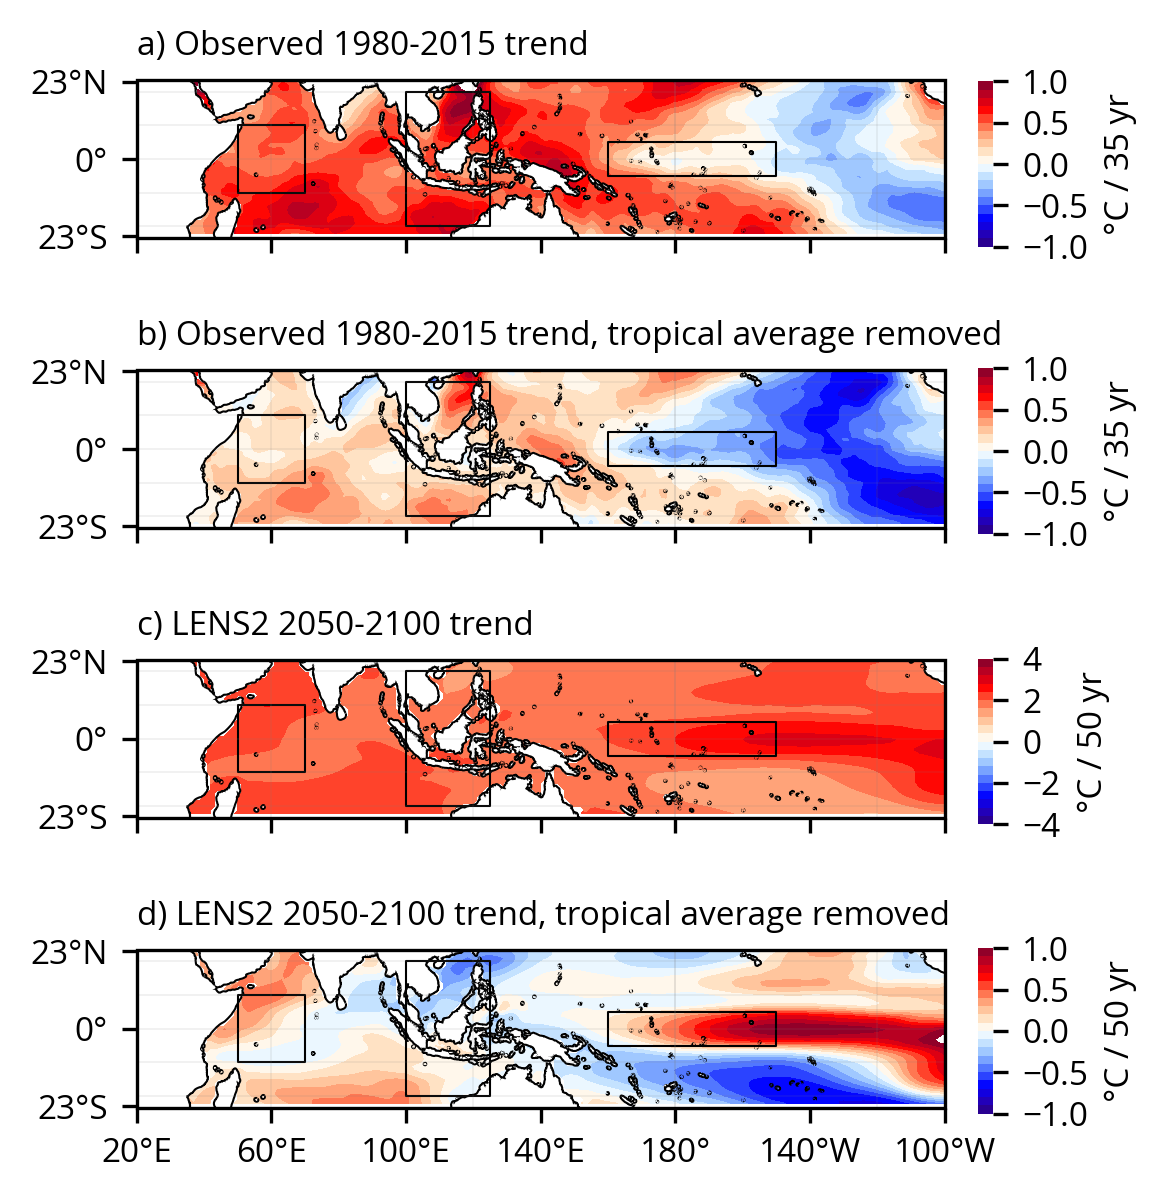

In [5]:
%matplotlib inline 

utils.set_matplotlib_font("Open Sans")

color = 'black'

mpl.rcParams.update({
    'axes.edgecolor': color,      # Color of the axes spines
    'xtick.color': color,         # Color of the x-axis ticks
    'ytick.color': color,         # Color of the y-axis ticks
    'xtick.labelcolor': color,    # Color of the x-axis tick labels
    'ytick.labelcolor': color,    # Color of the y-axis tick labels
    'grid.color': color,          # Color of the grid lines
    'axes.labelcolor': color,     # Color of the axis labels
    'axes.titlecolor': color,     # Color of the plot titles
})

mpl.rcParams['hatch.linewidth'] = 0.5  # previous pdf hatch linewidth

mpl.rcParams.update({
    'font.size': 8, 
    'axes.titlesize': 8, 
    'axes.labelsize': 8,
    'xtick.labelsize': 8, 
    'ytick.labelsize': 8, 
    'legend.fontsize': 8,
    'figure.titlesize': 8
})

fig_width_cm = 9.5
fig_height_cm = 10
fig_width_in = fig_width_cm / 2.54
fig_height_in = fig_height_cm / 2.54

fig = plt.figure(figsize=(fig_width_in, fig_height_in), dpi=300, constrained_layout=False)

gs1 = GridSpec(4, 1, top=0.95, bottom=0.05, left=0.1, right=0.82, hspace=0.5, wspace=0.2)

ax1 = fig.add_subplot(gs1[0, 0], projection=ccrs.PlateCarree(central_longitude=180))
ax2 = fig.add_subplot(gs1[1, 0], projection=ccrs.PlateCarree(central_longitude=180))
ax3 = fig.add_subplot(gs1[2, 0], projection=ccrs.PlateCarree(central_longitude=180))
ax4 = fig.add_subplot(gs1[3, 0], projection=ccrs.PlateCarree(central_longitude=180))

############## Figure 4a ##############
levels = np.linspace(-1, 1, 21)
peryears = 35
cbar_ticks = np.linspace(-1, 1, num=5) 

observed_slope = utils.calculate_sst_trend(obs_global_sst_climatology_regridded_da, 
        dim='datasets', start_year=1980, end_year=2015, relative=False)
trend_plot1 = plots.plot_sst_trends_spatial(observed_slope, ax1, peryears, levels)
ax1.set_title("a) Observed 1980-2015 trend", loc="left")

######## Colorbar for 4a ########
cbar_ax1 = fig.add_axes([0.85, 0.794, 0.013, 0.14]) # [left, bottom, width, height]
cbar1 = fig.colorbar(trend_plot1, cax=cbar_ax1, orientation="vertical", shrink=0.80, label='°C / 35 yr')
cbar1.ax.tick_params(labelsize=8)
cbar1.outline.set_visible(False)
cbar1.set_ticks(cbar_ticks)

############## Figure 4b ##############
observed_relative_slope = utils.calculate_sst_trend(obs_global_sst_climatology_regridded_da, 
        dim='datasets', start_year=1980, end_year=2015, relative=True)
trend_plot2 = plots.plot_sst_trends_spatial(observed_relative_slope, ax2, peryears, levels)
ax2.set_title("b) Observed 1980-2015 trend, tropical average removed", loc="left")

######## Colorbar for 4b ########
cbar_ax2 = fig.add_axes([0.85, 0.551, 0.013, 0.14]) # [left, bottom, width, height]
cbar2 = fig.colorbar(trend_plot2, cax=cbar_ax2, orientation="vertical", extend='neither', shrink=0.80, label='°C / 35 yr')
cbar2.ax.tick_params(labelsize=8)
cbar2.outline.set_visible(False)
cbar2.set_ticks(cbar_ticks)

############## Figure 4c ##############
levels = np.linspace(-4, 4, 21)
peryears = 50
cbar_ticks = np.linspace(-4, 4, num=5) 

modeled_slope = utils.calculate_sst_trend(cesm_global_djf_sst_map, 
        dim='ensemble', start_year=2050, end_year=2100, relative=False)
trend_plot3 = plots.plot_sst_trends_spatial(modeled_slope, ax3, peryears, levels)
ax3.set_title("c) LENS2 2050-2100 trend", loc="left")

######## Colorbar for 4c ########
cbar_ax3 = fig.add_axes([0.85, 0.305, 0.013, 0.14]) # [left, bottom, width, height]
cbar3 = fig.colorbar(trend_plot3, cax=cbar_ax3, orientation="vertical", shrink=0.80, label='°C / 50 yr')
cbar3.ax.tick_params(labelsize=8)
cbar3.outline.set_visible(False)
cbar3.set_ticks(cbar_ticks)

############## Figure 4d ##############
levels = np.linspace(-1, 1, 21)
peryears = 50
cbar_ticks = np.linspace(-1, 1, num=5) 

modeled_relative_slope = utils.calculate_sst_trend(cesm_global_djf_sst_map, 
        dim='ensemble', start_year=2050, end_year=2100, relative=True)
trend_plot4 = plots.plot_sst_trends_spatial(modeled_relative_slope, ax4, peryears, levels)
ax4.set_title("d) LENS2 2050-2100 trend, tropical average removed", loc="left")

######## Colorbar for 4d ########
cbar_ax4 = fig.add_axes([0.85, 0.06, 0.013, 0.14])  # [left, bottom, width, height]
cbar4 = fig.colorbar(trend_plot4, cax=cbar_ax4, orientation="vertical", shrink=0.80, label='°C / 50 yr')
cbar4.ax.tick_params(labelsize=8)
cbar4.outline.set_visible(False)
cbar4.set_ticks(cbar_ticks)

lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
axs = [ax1, ax2, ax3, ax4]
for i, ax in enumerate(axs):
    ax.set_yticks([-23, 0, 23], crs=ccrs.PlateCarree())
    ax.set_yticklabels([-23, 0, 23], fontsize=8)
    ax.tick_params(axis='y', which='major', labelsize=8)  # Set tick params for each ax
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.set_xticks([20, 60, 100, 140, 180, 220, 260], crs=ccrs.PlateCarree())
    ax.set_xticklabels([], fontsize=8)
    ax.set_extent([20, 260, -23.5, 23.5], crs=ccrs.PlateCarree())
    ax.gridlines(
            crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.1, color="gray", alpha=0.5
        )
    
    # Add land mask
    land_mask = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='none', facecolor='white')
    ax.coastlines(linewidth=1)
    ax.add_feature(land_mask)

    # Defined regions for the boxes
    geom = geometry.box(minx=50, maxx=70, miny=-10, maxy=10)
    ax.add_geometries([geom], crs=ccrs.PlateCarree(), edgecolor='k', facecolor='none', linewidth=0.5)
    geom = geometry.box(minx=100, maxx=125, miny=-20, maxy=20)
    ax.add_geometries([geom], crs=ccrs.PlateCarree(), edgecolor='k', facecolor='none', linewidth=0.5)
    geom = geometry.box(minx=160, maxx=210, miny=-5, maxy=5)
    ax.add_geometries([geom], crs=ccrs.PlateCarree(), edgecolor='k', facecolor='none', linewidth=0.5)

ax4.set_xticklabels([20, 60, 100, 140, 180, 220, 260], fontsize=8)
ax4.xaxis.set_major_formatter(lon_formatter)

plt.tight_layout()
plt.savefig("Fig5.png")
plt.savefig("Fig5.pdf")